# this is LSTM CODE for the rain model in UAE

In [6]:
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import array
from datetime import datetime
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from itertools import product
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from numpy import concatenate

In [7]:
# Data inputs
# 1. PAth where input file is stored
filepath = "C:\CDrive\C_FULL\PHD\Coding Section\Forecasting/Combined Dataset_v2.csv"

# 2. Row number of starting month
startrow_training = 0
endrow_training = 193
startrow_test = 194
endrow_test = 205

# 3. Dependent variable name
dependent_var = "DXB_Daily_Avg_SR"

# 4. Number of LSTM time steps 
n_steps = 1

# 5. Number of features. For a univariate series, the number of features is one, for one variable.
n_features = 1

# 6. Number of hidden LSTM layers
n_hidden = 500

# 7. Number of epochs of stochastic gradient descent
n_epochs = 500

In [8]:
df = pd.read_csv(filepath)
df.index.name = 'Month_Year'
df.set_index(df['Month_Year'], inplace=True) 

In [10]:
df.head(25)

,Day,Month,Year,Month_Year,DXB_Daily_Avg_SR
Month_Year,,,,,
1-Jan-03,1,Jan,2003,1-Jan-03,3.400000
1-Feb-03,1,Feb,2003,1-Feb-03,3.500000
1-Mar-03,1,Mar,2003,1-Mar-03,9.100000
1-Apr-03,1,Apr,2003,1-Apr-03,48.900000
1-May-03,1,May,2003,1-May-03,0.300000
1-Jun-03,1,Jun,2003,1-Jun-03,0.000000
1-Jul-03,1,Jul,2003,1-Jul-03,7.100000
1-Aug-03,1,Aug,2003,1-Aug-03,2.500000
1-Sep-03,1,Sep,2003,1-Sep-03,1.500000


In [11]:
# Divide the data into train and test datasets
train = df[dependent_var][startrow_training:endrow_training]
test = df[dependent_var][startrow_test:endrow_test]
train

Month_Year
1-Jan-03     3.4
1-Feb-03     3.5
1-Mar-03     9.1
1-Apr-03    48.9
1-May-03     0.3
            ... 
1-Sep-18     2.3
1-Oct-18     9.7
1-Nov-18     8.9
1-Dec-18     1.4
1-Jan-19     0.2
Name: DXB_Daily_Avg_SR, Length: 193, dtype: float64

In [12]:
test

Month_Year
1-Mar-19    11.6
1-Apr-19    15.6
1-May-19     5.2
1-Jun-19     4.0
1-Jul-19     7.0
1-Aug-19     5.3
1-Sep-19     3.4
1-Oct-19    12.9
1-Nov-19    16.4
1-Dec-19    10.5
Name: DXB_Daily_Avg_SR, dtype: float64

In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [14]:
colindex = df.columns.get_loc(dependent_var)
train_processed = df.iloc[startrow_training:endrow_training, colindex:colindex+1].values
#train_processed

In [15]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_processed)
#train_data_scaled

In [16]:
X, y = split_sequence(train_data_scaled, n_steps)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[[0.06181818]] [0.06363636]
[[0.06363636]] [0.16545455]
[[0.16545455]] [0.88909091]
[[0.88909091]] [0.00545455]
[[0.00545455]] [0.]
[[0.]] [0.12909091]
[[0.12909091]] [0.04545455]
[[0.04545455]] [0.02727273]
[[0.02727273]] [0.10363636]
[[0.10363636]] [0.05454545]
[[0.05454545]] [0.13636364]
[[0.13636364]] [0.26365455]
[[0.26365455]] [0.]
[[0.]] [0.01931515]
[[0.01931515]] [0.03909091]
[[0.03909091]] [0.01454545]
[[0.01454545]] [0.04290909]
[[0.04290909]] [0.0976993]
[[0.0976993]] [0.06454545]
[[0.06454545]] [0.08657708]
[[0.08657708]] [0.08323232]
[[0.08323232]] [0.12332273]
[[0.12332273]] [0.41218687]
[[0.41218687]] [0.35090909]
[[0.35090909]] [0.32181818]
[[0.32181818]] [0.12545455]
[[0.12545455]] [0.04181818]
[[0.04181818]] [0.04]
[[0.04]] [0.09818182]
[[0.09818182]] [0.17090909]
[[0.17090909]] [0.07454545]
[[0.07454545]] [0.09090909]
[[0.09090909]] [0.11090909]
[[0.11090909]] [0.11272727]
[[0.11272727]] [0.12363636]
[[0.12363636]] [0.01454545]
[[0.01454545]] [0.37636364]
[[0.376363

In [17]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(12345)
import random as rn
rn.seed(12345)
import tensorflow as tf
tf.random.set_seed(12345)
# LSTM
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model - RELU activation function, MSE as Loss function and Adam Gradient Descent as Optimizer
# 50 LSTM units in the hidden layer and an output layer that predicts a single numerical value
model = Sequential()
model.add(LSTM(n_hidden, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
#model.add(LSTM(n_hidden, activation='tanh'))
model.add(LSTM(n_hidden, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=n_epochs, verbose=0)
# Find predictions
yhat = model.predict(X, verbose=0)
print(yhat)

[[ 0.11883496]
 [ 0.11988623]
 [ 0.17385495]
 [ 0.02072663]
 [ 0.08631738]
 [ 0.08358285]
 [ 0.15824828]
 [ 0.10937906]
 [ 0.09888408]
 [ 0.14324865]
 [ 0.11463111]
 [ 0.16254005]
 [ 0.16406702]
 [ 0.08358285]
 [ 0.0942947 ]
 [ 0.10570443]
 [ 0.09154727]
 [ 0.10790902]
 [ 0.13975419]
 [ 0.12041191]
 [ 0.13321087]
 [ 0.13124394]
 [ 0.15484558]
 [ 0.16212817]
 [ 0.1648628 ]
 [ 0.16449235]
 [ 0.15610301]
 [ 0.10727908]
 [ 0.10622927]
 [ 0.14003815]
 [ 0.1732162 ]
 [ 0.12619638]
 [ 0.13575897]
 [ 0.14753078]
 [ 0.14860159]
 [ 0.15503056]
 [ 0.09154727]
 [ 0.1652664 ]
 [ 0.17112847]
 [ 0.09364177]
 [ 0.08527401]
 [ 0.17006414]
 [ 0.1051796 ]
 [ 0.16146696]
 [ 0.16923523]
 [ 0.1240925 ]
 [ 0.17323673]
 [-0.00709075]
 [ 0.09993304]
 [ 0.16898073]
 [ 0.1647343 ]
 [ 0.11358047]
 [ 0.09678657]
 [ 0.1411082 ]
 [ 0.10937906]
 [ 0.13789836]
 [ 0.12724847]
 [ 0.15717559]
 [ 0.08945413]
 [ 0.10203129]
 [ 0.03556515]
 [ 0.08631738]
 [ 0.08358285]
 [ 0.08631738]
 [ 0.09678657]
 [ 0.08358285]
 [ 0.15395

In [18]:
# fit model
#model.fit(X, y, epochs=n_epochs, verbose=0)
# Find predictions
#yhat = model.predict(X, verbose=0)
#print(yhat)

In [19]:
predictions_train = scaler.inverse_transform(yhat)
Actual_train = scaler.inverse_transform(y)

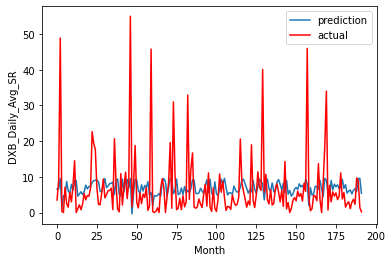

In [20]:
plt.plot(predictions_train,label='prediction')
plt.plot(Actual_train,color='red',label='actual')
plt.ylabel(dependent_var)
plt.xlabel('Month')
plt.legend()
plt.show()

In [21]:
def forecast_accuracy(forecast, actual):
   
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
 
    
    return({'me':me, 'mae': mae, 
            })

forecast_accuracy(predictions_train, Actual_train)

{'me': 0.23065717149566622, 'mae': 5.297757877391898}

In [22]:
test_inputs_act = df[dependent_var][startrow_test - n_steps:endrow_test].values
test_inputs_act = test_inputs_act.reshape(-1,1)
test_inputs_act = scaler.transform(test_inputs_act)
test_inputs_act

array([[0.16363636],
       [0.21090909],
       [0.28363636],
       [0.09454545],
       [0.07272727],
       [0.12727273],
       [0.09636364],
       [0.06181818],
       [0.23454545],
       [0.29818182],
       [0.19090909]])

In [29]:
test_inputs_act.shape

(11, 1)

In [30]:
test_features_act = []
for i in range(n_steps, test_inputs_act.shape[0]):
    test_features_act.append(test_inputs_act[i-n_steps:i, 0])
test_features_act

[array([0.16363636]),
 array([0.21090909]),
 array([0.28363636]),
 array([0.09454545]),
 array([0.07272727]),
 array([0.12727273]),
 array([0.09636364]),
 array([0.06181818]),
 array([0.23454545]),
 array([0.29818182])]

In [31]:
test_features_act = np.array(test_features_act)
test_features_act = np.reshape(test_features_act, (test_features_act.shape[0], test_features_act.shape[1], 1))
predictions_act_test = model.predict(test_features_act)
predictions_act_test1 = scaler.inverse_transform(predictions_act_test)
predictions_act_test1

array([[9.573766 ],
       [9.273923 ],
       [9.029579 ],
       [7.5844097],
       [6.88294  ],
       [8.644657 ],
       [7.643251 ],
       [6.535923 ],
       [9.12827  ],
       [9.035283 ]], dtype=float32)

In [27]:
forecast_accuracy(predictions_act_test1[:,0], test_data1)

{'me': -0.8567998313903807, 'mae': 3.857179222106933}